In [1]:
library(yardstick)
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(recipes)
install.packages("themis")
library(themis)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ readr::spec()   masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.8
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1

── Conflicts ───────────────────────────────────────

## Introduction

- Wine quality highly depends on its composition of various aromatic compounds. By assessing the content of wines such as their sugar content and pH value, we will be able to determine how good the wine is. 
- In this project, we will be using the wine quality dataset obtained from a web URL.
- We want to solve **regression problem** —- what would be the wine’s quality level given its values on the fixed acidity, volatile acidity, and other variables.
-  7 out of the 12 variables are used to predict the **wine quality**, which ranges from 0 to 10, with 10 being the highest quality wine.
- We focus on indicating which attributes affect the wine quality and predicting the quality based on each attribute's values. By using the regression method, we create a linear formula and use the coefficients to know how the attribute level influences the wine quality(i.e. it positively/negatively influences the wine quality).

## Preliminary exploratory data analysis

**1. Data Reading**

In [2]:
temp <- tempfile()
download_file <- download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", temp)
red_wine <- read.csv2(unz(temp, "winequality-red.csv")) |>
             mutate(type = 0)
white_wine <- read.csv2(unz(temp, "winequality-white.csv")) |>
              mutate(type = 1)
unlink(temp)

**2. Data Wrangling**

In [3]:
wine_data <- rbind(red_wine, white_wine) |>
             mutate(across(fixed.acidity:alcohol, as.numeric), type = as_factor(type))

write_csv(wine_data, "../data/wine_data.csv")

**3. Data Splitting**

To know how good our prediction is, we should split our data into training dataset and testing dataset.

In [4]:
set.seed(2000)
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

**4. Summarization**

**a. The number of observations in each red wine/white wine class**

In [5]:
wine_type_number <- wine_training |>
                    group_by(type) |>
                    summarize(Number = n())
wine_type_number

type,Number
<fct>,<int>
0,1220
1,3652


- We have 4898 observations for White wine and 1599 observations for Red wine.
- There is an imbalance between the types of the wine. 

**b. The number of observations for each quality level.**

In [6]:
quality_number <- wine_training |>
                  group_by(quality) |>
                  summarize(Number = n())
quality_number

quality,Number
<int>,<int>
3,26
4,162
5,1600
6,2127
7,810
8,143
9,4


**c. Mean value of each measurements for different quality type.**

In [7]:
mean_measurements <- wine_training |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
mean_measurements

quality,mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_sufdioxide,mean_tot_sufdioxide,mean_density,mean_ph,mean_sulphates,mean_alcohol
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.807692,0.5182692,0.2715385,4.623077,0.07911538,42.51923,129.6923,0.9954881,3.253846,0.5069231,10.201923
4,7.323457,0.4564815,0.2803704,4.264198,0.06016049,21.56790,105.3241,0.9949722,3.227284,0.5123457,10.158642
5,7.335750,0.3938531,0.3059750,5.805750,0.06529562,30.25156,120.7506,0.9958872,3.209694,0.5275750,9.829279
6,7.190574,0.3153220,0.3236624,5.550987,0.05421909,31.05125,115.0835,0.9945737,3.216878,0.5338834,10.587980
7,7.067284,0.2898704,0.3308889,4.644198,0.04461975,30.52963,108.4975,0.9930078,3.229975,0.5450864,11.395144
8,6.905594,0.2984965,0.3374825,5.098601,0.04057343,35.45455,116.3077,0.9924151,3.218531,0.5192308,11.746154
9,7.000000,0.3050000,0.3700000,2.500000,0.02550000,34.75000,114.0000,0.9900750,3.335000,0.4675000,12.625000


The ranges of the mean are different across different columns hence the variables will need to be scaled 

**d. Missing data - We have no missing data in this dataset.**

**4. Visualization: histogram between quality and other numeric variables**

Warning message:
“ There was 1 column that was a factor when the recipe was prepped:
 'quality'.
 This may cause errors when processing new data.”


# A tibble: 1 × 2
  quality count
  <fct>   <int>
1 NA      32788


Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails 

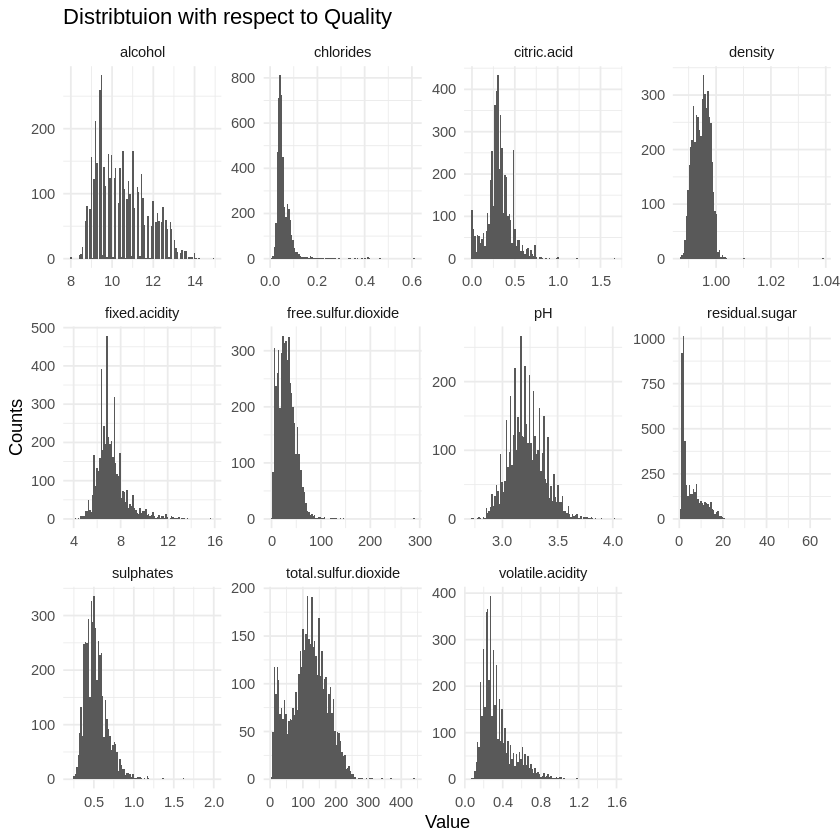

In [77]:
# # Gather data for facetting
# gathered_data <- wine_training |>
#   gather(key = "variable", value = "value", -c("quality", "type"))

# # Create facetted histograms
# facet_histograms <- ggplot(gathered_data, aes(x = value, fill = quality)) +
#   geom_histogram(position = "dodge", bins = 100) +
#   labs(title = "Distribtuion with respect to Quality", x = "Value", y = "Counts", fill = "Quality") +
#   facet_wrap(~variable, scales = "free") +
#   theme_minimal()

# # Display facetted histograms
# print(facet_histograms)

- Most variables have a linear negative correlation to quality
- free.sulfur.dioxide and total.sulfur. dioxide seems to have no correlation with quality as the categories' bins are layered in the histogram.
- alcohol and residual.sugar have a non-linear relationship with quality

## Training & Evaluation

### 1. The multivariable Linear regression Model

In [9]:
set.seed(1)
wine_data_reg <- wine_training |>
                  mutate(quality = as.numeric(quality)) |>
                  select(alcohol, density, volatile.acidity, quality)
head(wine_data_reg)

,alcohol,density,volatile.acidity,quality
,<dbl>,<dbl>,<dbl>,<dbl>
1,9.4,0.9978,0.70,5
2,9.8,0.9968,0.88,5
3,9.8,0.9970,0.76,5
4,9.4,0.9978,0.66,5
5,9.2,0.9959,0.58,5
6,10.5,0.9978,0.50,5


In [10]:
lm_recipe <- recipe(quality ~ .,
                     data = wine_data_reg)

lm_spec <- linear_reg() |>
   set_engine("lm") |>
   set_mode("regression")

lm_fit <- workflow() |>
   add_recipe(lm_recipe) |>
   add_model(lm_spec) |>
   fit(data = wine_data_reg)

 lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)           alcohol           density  volatile.acidity  
         -29.469             0.378            31.988            -1.461  


In [11]:
lm_test_results <- lm_fit |>
                   predict(wine_testing) |>
                   bind_cols(wine_testing) |>
                   mutate(quality = ifelse(quality <= 5, "Low", "High"), .pred = ifelse(.pred <= 5, "Low", "High"))|>
                   mutate(quality = as.factor(quality), .pred = as.factor(.pred)) |>
                   metrics(truth = quality, estimate = .pred) |>
                   filter(.metric == "accuracy")

lm_test_results
    

lm_coeffs <- lm_fit |>
              extract_fit_parsnip() |>
              tidy()
 lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6492308


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-29.4685309,5.23357578,-5.630669,1.895868e-08
alcohol,0.3780345,0.01256460,30.087264,1.497664e-182
density,31.9882324,5.17551216,6.180689,6.902877e-10
volatile.acidity,-1.4613119,0.06837024,-21.373508,5.947060e-97


The RMSPE of this linear regression model is 0.7961641

The mathematical expression to describe this linear regression model is:
$quality = 3.81887647 + 0.09180436 \cdot (fixed.acidity) - 0.19801129 \cdot (volatile.acidity) + 0.01694675 \cdot (citric.acid) - 0.08928023 \cdot (chlorides) - 0.08928023 \cdot (density) + 0.07583322 \cdot (pH) + 0.13697853 \cdot (sulphates)$

In [12]:
# knn_recipe <- recipe(quality ~ ., data = wine_data_reg) |>
#   step_scale(all_numeric_predictors()) |>
#   step_center(all_numeric_predictors())

In [13]:
# wine_knnreg_spec <- nearest_neighbor(weight_func = "rectangular",
#                                      neighbors = tune()) |>
#                     set_engine("kknn") |>
#                     set_mode("regression")

In [14]:
# knn_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

# knn_workflow <- workflow() |>
#     add_recipe(knn_recipe) |>
#     add_model(wine_knnreg_spec)

# knn_workflow

In [15]:
# gridvals <- tibble(neighbors = seq(from = 10, to = 100, by = 10))

# knn_reg_results <- knn_workflow |>
#   tune_grid(resamples = knn_vfold, grid = gridvals)
#show the results
#head(knn_reg_results)

In [16]:
# knn_min <- knn_reg_results |>
#     filter(mean == min(mean))
# knn_min

The smallest RMSPE occurs when K = 19.

In [17]:
# kmin <- knn_min |> pull(neighbors)

# knn_reg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
#   set_engine("kknn") |>
#   set_mode("regression")

# knn_reg_fit <- workflow() |>
#   add_recipe(knn_recipe) |>
#   add_model(knn_reg_spec) |>
#   fit(data = wine_reg_training)

# knn_reg_summary <- knn_reg_fit |>
#   predict(wine_reg_testing) |>
#   bind_cols(wine_reg_testing) |>
#   metrics(truth = quality, estimate = .pred) |>
#   filter(.metric == 'rmse')

# knn_reg_summary

### 2. Classification Model

In [18]:
wine_cl <- wine_data |>
            mutate(quality = ifelse(quality < 5, "Low", "High"))|>
            mutate(quality = as.factor(quality)) |>
            select(alcohol, density, volatile.acidity, quality)

In [19]:
head(wine_cl)

,alcohol,density,volatile.acidity,quality
,<dbl>,<dbl>,<dbl>,<fct>
1,9.4,0.9978,0.70,High
2,9.8,0.9968,0.88,High
3,9.8,0.9970,0.76,High
4,9.8,0.9980,0.28,High
5,9.4,0.9978,0.70,High
6,9.4,0.9978,0.66,High


In [20]:
# Split the data
wine_class_split <- initial_split(wine_cl, prop = 0.75, strata = quality)
wine_class_training <- training(wine_class_split)
wine_class_testing <- testing(wine_class_split)

In [21]:
# Create a recipe
knn_recipe <- recipe(quality ~ ., data = wine_class_training) |>
              step_upsample(quality, over_ratio = 1, skip = TRUE) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

In [23]:
wine_vfold <- vfold_cv(wine_class_training, v = 5, strata = quality)

In [24]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

In [25]:
knn_fit <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = wine_vfold, grid = gridvals) 

In [26]:
knn_eval_rst <- knn_fit |>
                collect_metrics() |>
                filter(.metric == "accuracy")

top_5_neighbor <-  knn_eval_rst |>
                   slice_max(order_by = mean, n = 5)

top_5_neighbor

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9443772,5,0.003716021,Preprocessor1_Model01
11,accuracy,binary,0.8195832,5,0.002933154,Preprocessor1_Model02
21,accuracy,binary,0.7270095,5,0.003154391,Preprocessor1_Model03
71,accuracy,binary,0.6964296,5,0.004656345,Preprocessor1_Model08
61,accuracy,binary,0.6796007,5,0.006496303,Preprocessor1_Model07


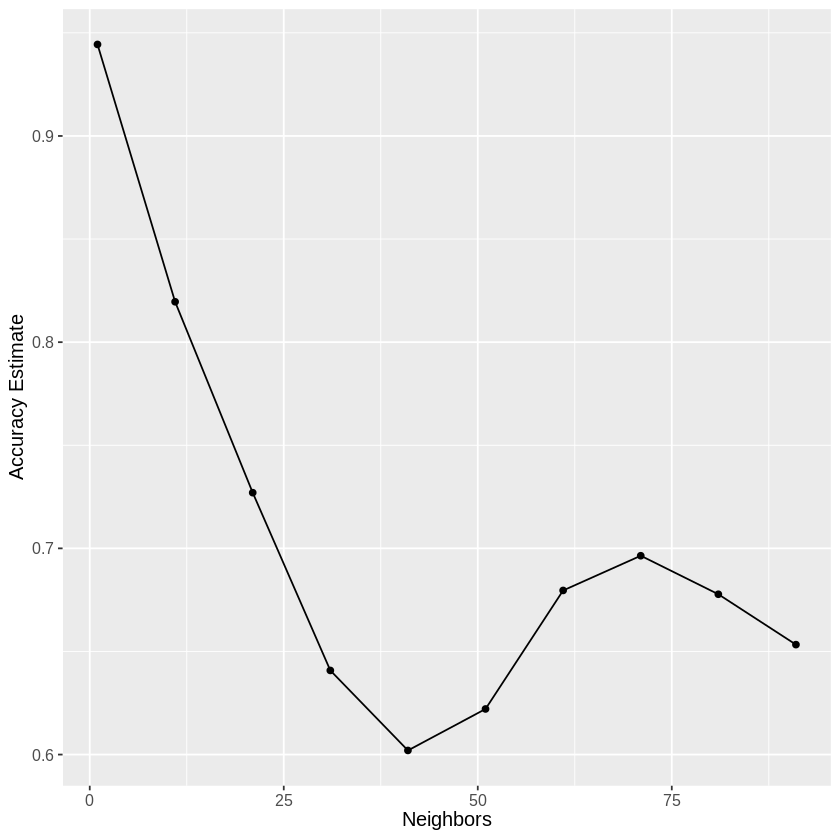

In [27]:
accuracy_vs_k <- ggplot(knn_eval_rst, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [28]:
best_k <- knn_fit |>
          select_best("accuracy") |>
          pull(neighbors) 
best_k

[1] 1

In [29]:
knn_spec_final <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                  set_engine("kknn") |>
                  set_mode("classification")

In [30]:
knn_fit_final <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec_final) |>
                fit(data = wine_class_training)

In [31]:
knn_pred <- predict(knn_fit_final, wine_class_testing) |>
            bind_cols(wine_class_testing)

In [32]:
testing_rst <- metrics(knn_pred, truth = quality, estimate = .pred_class) |>
               filter(.metric == "accuracy")

testing_rst

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9329231


The accuracy observed in this classification model is 0.9329231.

In [33]:
confusion <- knn_pred |>
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction High  Low
      High 1504   59
      Low    50   12

## Methods

- After data reading and wrangling, we used all 12 variables for preliminary data summarization and visualization. We then compared the number of observations in each red/ white wine class, the number of observations in each quality level for red and white wine respectively, and the mean value of each feature for each quality level. 

- Multi-histogram is used to visualize the relationship between each variable and the wine quality, each with one predictor on the x axis, counts on the y axis, and color indicating the different quality levels. If each quality level tends to show up on a certain value of the x axis, we can conclude that there is linear correlation between the wine quality and that predictor. Otherwise, there is no correlation or non-linear correlation. 

- **We will only use 7 numeric variables excluding type total.sulfur.dioxide, free.sulfur.dioxide, residual sugar and alcohol** 

## Expected outcomes and significance

- Due to class imbalance in the categories of the target column (quality): some of the categories are missing. We expect the model will be less precise for the level from 0 to 2 and the level 10.
- However, we hope the model will be able to predict correctly the quality from 3 - 8

- These findings will allow a more efficient and more systematic wine quality assessment as we will be able assess the quality of the wines not only by its age or individual tastes, but also the actual content in the wine itself.
-  The findings can also lead to further discoveries such as how different environments in which the grapes grew in would affect the quality of the wines, in which they can be used to optimize the wine development.
